In [1]:
# Pytorch is library for dealing with neural networks (and automatic gradients)
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torchvision is helper library for pytorch to deal with computer vision
import torchvision

import matplotlib.pyplot as plt

In [2]:
"""Prepare dataset"""
batch_size_train = 256
batch_size_test = 1024

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

/home/usamec/anaconda3/envs/magic_train/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# What is in train?
for x, y in train_loader:
    print(x.shape, y.shape, y[:10])
    break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor([6, 7, 1, 8, 1, 0, 2, 0, 1, 4])


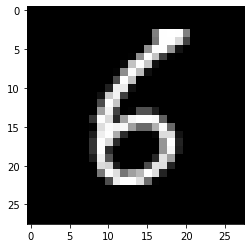

In [11]:
# X: 256 images, 1 channel (black/white), 28x28 image
# We will flatten each image into one vector for now
# Y: One number (category of image)
# Images looks like this:

plt.imshow(x[0,0], cmap="gray")

In [14]:
# Simple linear model from last lecture
# This just computes scores for each class
model_linear = nn.Linear(28*28, 10)
[(name, p.shape) for name, p in model_linear.named_parameters()]

[('weight', torch.Size([10, 784])), ('bias', torch.Size([10]))]

In [6]:
# Let's compute loss for one batch of images
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss

tensor(2.5320, grad_fn=<NllLossBackward>)

In [7]:
# Pytorch has many loss functions, which look similar but take different things,
# so take care
# Here cross entropy(output, y) is same as nll_loss(log_softmax(output), y)
loss2 = F.cross_entropy(output, y)
loss2

tensor(2.5320, grad_fn=<NllLossBackward>)

In [8]:
# If we want to train model, we need to get gradients
# This is easy, gradient will magically appear
loss.backward()
model_linear.weight.grad

# If you really want to do things by hand
# model_linear.weight.data = model_linear.weight.data - 0.01 * model_linear.weight.grad

tensor([[ 0.0143,  0.0143,  0.0143,  ...,  0.0143,  0.0143,  0.0143],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [ 0.0078,  0.0078,  0.0078,  ...,  0.0078,  0.0078,  0.0078],
        ...,
        [ 0.0015,  0.0015,  0.0015,  ...,  0.0015,  0.0015,  0.0015],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020]])

In [9]:
# If we calculate gradient second time, it will accumulate
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss.backward()
model_linear.weight.grad

tensor([[ 0.0287,  0.0287,  0.0287,  ...,  0.0287,  0.0287,  0.0287],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [ 0.0156,  0.0156,  0.0156,  ...,  0.0156,  0.0156,  0.0156],
        ...,
        [ 0.0030,  0.0030,  0.0030,  ...,  0.0030,  0.0030,  0.0030],
        [ 0.0018,  0.0018,  0.0018,  ...,  0.0018,  0.0018,  0.0018],
        [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039]])

In [19]:
# Lets optimize
model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(5):
    total_loss = 0
    total_loss_cc = 0
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
    print("epoch", epoch, "training loss", total_loss / total_loss_cc)

epoch 0 training loss 2.0181326366485433
epoch 1 training loss 1.2772354445558913
epoch 2 training loss 1.1178911808957446
epoch 3 training loss 1.1445766304401641
epoch 4 training loss 1.1019404127242718


In [24]:
# Optimize and compute training accuracy
# Lets optimize
model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(5):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
    print("epoch", epoch, "training loss", total_loss / total_loss_cc, "training accuracy", total_good / total_samples)

epoch 0 training loss 2.263542784782166 training accuracy 0.8371833333333333
epoch 1 training loss 1.3244583349278634 training accuracy 0.8687166666666667
epoch 2 training loss 1.3150952821082258 training accuracy 0.8758166666666667
epoch 3 training loss 1.1531251842671253 training accuracy 0.8804166666666666
epoch 4 training loss 1.0939914165659155 training accuracy 0.8787833333333334


In [28]:
# Optimize and compute training accuracy
# Also compute test accuracy

model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(20):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))
    
# TODO: lower learning rate (either continuously with scheduler, or just divide it by 10 after 10 and 15th epoch)

epoch 0 training loss 1.999 training accuracy 0.835 testing accuracy 0.885
epoch 1 training loss 1.332 training accuracy 0.867 testing accuracy 0.891
epoch 2 training loss 1.178 training accuracy 0.877 testing accuracy 0.870
epoch 3 training loss 1.069 training accuracy 0.879 testing accuracy 0.907
epoch 4 training loss 1.116 training accuracy 0.879 testing accuracy 0.856
epoch 5 training loss 1.158 training accuracy 0.880 testing accuracy 0.796
epoch 6 training loss 0.998 training accuracy 0.889 testing accuracy 0.772
epoch 7 training loss 1.038 training accuracy 0.887 testing accuracy 0.905
epoch 8 training loss 1.115 training accuracy 0.883 testing accuracy 0.843
epoch 9 training loss 0.961 training accuracy 0.890 testing accuracy 0.875
epoch 10 training loss 1.059 training accuracy 0.885 testing accuracy 0.799
epoch 11 training loss 0.993 training accuracy 0.888 testing accuracy 0.843
epoch 12 training loss 0.959 training accuracy 0.889 testing accuracy 0.855
epoch 13 training loss

In [30]:
# Let's train neural network, we only change model and maybe learning rate

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
optimizer = torch.optim.SGD(model.parameters(), lr=1)

for epoch in range(20):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.545 training accuracy 0.575 testing accuracy 0.710
epoch 1 training loss 0.510 training accuracy 0.849 testing accuracy 0.914
epoch 2 training loss 0.294 training accuracy 0.918 testing accuracy 0.841
epoch 3 training loss 0.259 training accuracy 0.928 testing accuracy 0.831
epoch 4 training loss 0.285 training accuracy 0.917 testing accuracy 0.914
epoch 5 training loss 0.197 training accuracy 0.944 testing accuracy 0.935
epoch 6 training loss 0.166 training accuracy 0.952 testing accuracy 0.944
epoch 7 training loss 0.147 training accuracy 0.957 testing accuracy 0.930
epoch 8 training loss 0.129 training accuracy 0.961 testing accuracy 0.945
epoch 9 training loss 0.119 training accuracy 0.964 testing accuracy 0.955
epoch 10 training loss 0.108 training accuracy 0.967 testing accuracy 0.955
epoch 11 training loss 0.097 training accuracy 0.970 testing accuracy 0.956
epoch 12 training loss 0.091 training accuracy 0.972 testing accuracy 0.959
epoch 13 training loss

In [33]:
# More hidden layers
# And cuda

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(20):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.cuda().flatten(1))
        y = y.cuda()
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        y = y.cuda()
        output = model(x.cuda().flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 0.714 training accuracy 0.787 testing accuracy 0.928
epoch 1 training loss 0.216 training accuracy 0.936 testing accuracy 0.946
epoch 2 training loss 0.150 training accuracy 0.954 testing accuracy 0.958
epoch 3 training loss 0.115 training accuracy 0.966 testing accuracy 0.962
epoch 4 training loss 0.091 training accuracy 0.973 testing accuracy 0.968
epoch 5 training loss 0.073 training accuracy 0.978 testing accuracy 0.972
epoch 6 training loss 0.060 training accuracy 0.982 testing accuracy 0.974
epoch 7 training loss 0.050 training accuracy 0.985 testing accuracy 0.977
epoch 8 training loss 0.042 training accuracy 0.988 testing accuracy 0.957
epoch 9 training loss 0.036 training accuracy 0.990 testing accuracy 0.977
epoch 10 training loss 0.029 training accuracy 0.992 testing accuracy 0.972
epoch 11 training loss 0.025 training accuracy 0.993 testing accuracy 0.979
epoch 12 training loss 0.021 training accuracy 0.994 testing accuracy 0.978
epoch 13 training loss

In [36]:
# Convolution network
model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=1, stride=2),  # Here we get 14x14 image with 16 channels
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(20):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.cuda())
        y = y.cuda()
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        y = y.cuda()
        output = model(x.cuda())
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 0.717 training accuracy 0.781 testing accuracy 0.952
epoch 1 training loss 0.132 training accuracy 0.961 testing accuracy 0.955
epoch 2 training loss 0.088 training accuracy 0.973 testing accuracy 0.926
epoch 3 training loss 0.070 training accuracy 0.979 testing accuracy 0.973
epoch 4 training loss 0.059 training accuracy 0.982 testing accuracy 0.976
epoch 5 training loss 0.050 training accuracy 0.985 testing accuracy 0.975
epoch 6 training loss 0.046 training accuracy 0.986 testing accuracy 0.985
epoch 7 training loss 0.040 training accuracy 0.987 testing accuracy 0.980
epoch 8 training loss 0.038 training accuracy 0.988 testing accuracy 0.982
epoch 9 training loss 0.034 training accuracy 0.989 testing accuracy 0.984
epoch 10 training loss 0.030 training accuracy 0.991 testing accuracy 0.986
epoch 11 training loss 0.028 training accuracy 0.991 testing accuracy 0.985
epoch 12 training loss 0.026 training accuracy 0.992 testing accuracy 0.985
epoch 13 training loss